In [2]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
reviews = pd.read_csv('../data/Las_Vegas_400_reviews.csv')

In [3]:
reviews.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date
0,409qhf4RF0rlxcuaM576Qg,El Pollo Loco,5260 S Ft Apache,Las Vegas,NV,89148,36.0941,-115.296839,2.5,108,1,"{'RestaurantsAttire': ""'casual'"", 'GoodForKids...","Restaurants, Mexican, Fast Food","{'Monday': '0:0-0:0', 'Tuesday': '9:30-23:0', ...",GmXOSEbXy8JXmvo9hM5WWQ,2.0,Came here quickly today to grab a burrito with...,2015-09-09 23:09:37
1,409qhf4RF0rlxcuaM576Qg,El Pollo Loco,5260 S Ft Apache,Las Vegas,NV,89148,36.0941,-115.296839,2.5,108,1,"{'RestaurantsAttire': ""'casual'"", 'GoodForKids...","Restaurants, Mexican, Fast Food","{'Monday': '0:0-0:0', 'Tuesday': '9:30-23:0', ...",P8Rn03SOJg0NnExbOWhLZw,1.0,I really like el pollo loco but some things no...,2014-04-20 03:16:46


# Feature Engineering

In [10]:
# Character count
reviews['char_count'] = reviews['text'].str.len()

# Word count
reviews['word_count'] = reviews['text'].str.split().str.len()

In [11]:
# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# From DSI Lesson 5.04-NLP-II
def get_vader_neg(text):
    return analyzer.polarity_scores(text)['neg']
def get_vader_neu(text):
    return analyzer.polarity_scores(text)['neu']
def get_vader_pos(text):
    return analyzer.polarity_scores(text)['pos']
def get_vader_comp(text):
    return analyzer.polarity_scores(text)['compound']

reviews['vader_neg'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
reviews['vader_neu'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
reviews['vader_pos'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
reviews['vader_comp'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [12]:
# save with engineered features
reviews.to_csv('../data/reviews_with_eng_feats')

---

In [43]:
# read in csv so it isn't necessary to run vader../data/ent every time
reviews = pd.read_csv('../data/reviews_with_eng_feats', index_col=0)

In [45]:
# Separate into dataframes by open and closed
open_reviews = reviews.loc[reviews['is_open']==1]
closed_reviews = reviews.loc[reviews['is_open']==0]

# Basic Analysis

In [8]:
# number of unique businesses
len(reviews['business_id'].unique())

400

In [9]:
# count of reviews by open or closed
reviews['is_open'].value_counts()

1    37211
0    36067
Name: is_open, dtype: int64

In [10]:
# Correlation of stars to open or closed
reviews[['is_open', 'stars']].corr()

,is_open,stars
is_open,1.000000,0.015415
stars,0.015415,1.000000


In [11]:
# Statistics of star ratings for closed
closed_reviews[['stars']].describe().T

,count,mean,std,min,25%,50%,75%,max
stars,36067.0,3.714628,0.579305,2.0,3.5,3.5,4.0,5.0


In [12]:
# Statistics of star ratings for open
open_reviews[['stars']].describe().T

,count,mean,std,min,25%,50%,75%,max
stars,37211.0,3.733882,0.665168,1.5,3.5,4.0,4.0,5.0


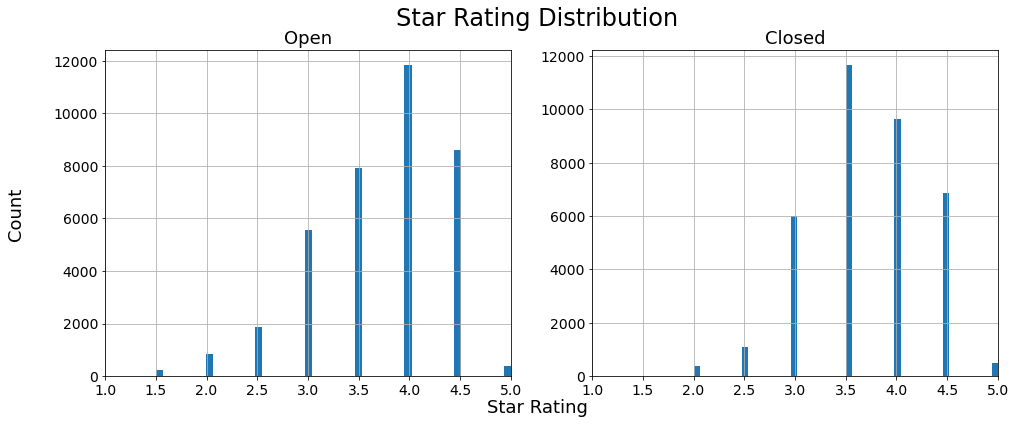

In [57]:
# Plot Stars Distribution
fig, ax = plt.subplots(1, 2, figsize=(16,6))
open_reviews['stars'].hist(bins=50, ax=ax[0], 
                              xlabelsize=14, ylabelsize=14)
closed_reviews['stars'].hist(bins=50, ax=ax[1],
                                 xlabelsize=14, ylabelsize=14)

ax[0].set_xlim([1,5])
ax[0].set_title('Open', fontsize=18)

ax[1].set_xlim([1,5])
ax[1].set_title('Closed', fontsize=18)

fig.suptitle('Star Rating Distribution', fontsize=24)
fig.text(0.5, 0.04, 'Star Rating', 
         ha='center', fontsize=18)
fig.text(0.04, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=18);
#plt.savefig('../presentation/images/star_rating_dist.png')

#### Results
The number of stars is not highly related to whether or not the restaurant is open or closed.

# Character and Word Count Distributions

#### Character

In [13]:
# Closed restaurants review length statistics
closed_reviews[['char_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
char_count,36067.0,608.89636,578.691028,5.0,230.0,420.0,781.0,4999.0


In [14]:
# Open restaurants review length statistics
open_reviews[['char_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
char_count,37211.0,489.005402,457.449748,5.0,199.0,342.0,615.0,5000.0


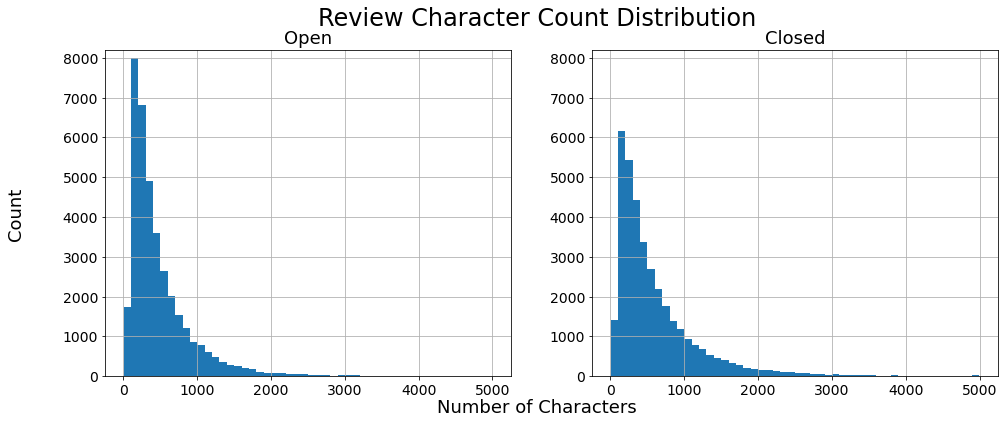

In [58]:
# Plot character count distributions
fig, ax = plt.subplots(1, 2, figsize=(16,6))
open_reviews['char_count'].hist(bins=50, ax=ax[0], 
                              xlabelsize=14, ylabelsize=14)
closed_reviews['char_count'].hist(bins=50, ax=ax[1],
                                 xlabelsize=14, ylabelsize=14)

ax[0].set_ylim([0,8200])
ax[0].set_title('Open', fontsize=18)

ax[1].set_ylim([0,8200])
ax[1].set_title('Closed', fontsize=18)

fig.suptitle('Review Character Count Distribution', fontsize=24)
fig.text(0.5, 0.04, 'Number of Characters', 
         ha='center', fontsize=18)
fig.text(0.04, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=18);
#plt.savefig('../presentation/images/char_count_dist.png')

#### Words

In [15]:
# Closed restaurants review length statistics
closed_reviews[['word_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,36067.0,112.685142,106.670853,1.0,42.0,78.0,145.5,965.0


In [16]:
# Open restaurants review length statistics
open_reviews[['word_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,37211.0,91.071189,85.492903,1.0,36.0,64.0,115.0,972.0


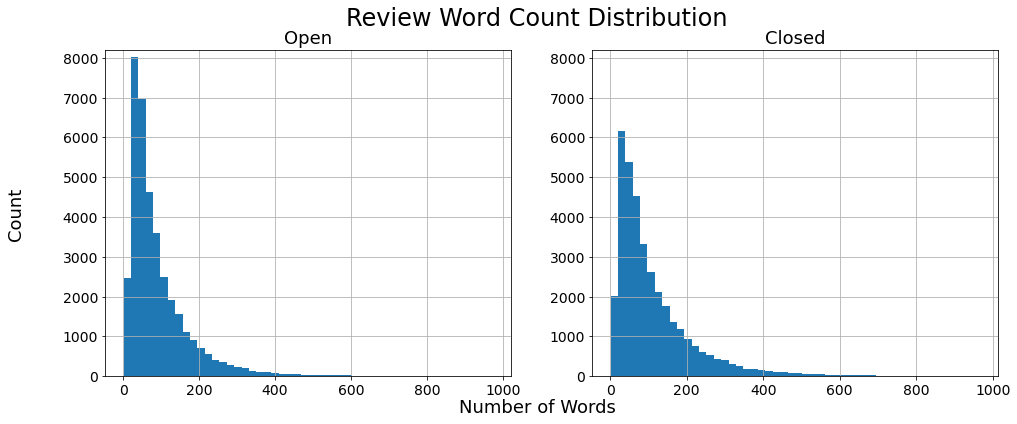

In [19]:
# Plot character count distributions
fig, ax = plt.subplots(1, 2, figsize=(16,6))
open_reviews['word_count'].hist(bins=50, ax=ax[0], 
                              xlabelsize=14, ylabelsize=14)
closed_reviews['word_count'].hist(bins=50, ax=ax[1],
                                 xlabelsize=14, ylabelsize=14)

ax[0].set_ylim([0,8200])
ax[0].set_title('Open', fontsize=18)

ax[1].set_ylim([0,8200])
ax[1].set_title('Closed', fontsize=18)

fig.suptitle('Review Word Count Distribution', fontsize=24)
fig.text(0.5, 0.04, 'Number of Words', 
         ha='center', fontsize=18)
fig.text(0.04, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=18);
#plt.savefig('../presentation/images/word_count_dist.png')

# Most Frequent Words

In [5]:
# using isalnum method to remove special characters from
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string

def my_preprocessor(text):
    """Process text for use with vectorizer.
    
    Takes in a string and modifies it for use with count or tf-idf
    vectorizer.  It will set all characters to lowercase, remove and urls,
    remove the apostrophe from contractions, and replace non-alphanumeric
    characters with a space.
    
    Args:
        text (string): string to be processed
    
    Returns:
        string: processed text string
    """
    text = text.lower()
    text = re.sub('http\S+|www.\S+', '', text)
    text = text.replace("'", '')
    text = ''.join(w if w.isalnum() or w == ' ' else ' ' for w in text)
    
    return text

In [6]:
def my_lemmatizer(text):
    wnet = WordNetLemmatizer()
    return [wnet.lemmatize(w) for w in word_tokenize(text)]

In [7]:
# Download stopwords from nltk
# Uncomment line below and run if necessary
#nltk.download('stopwords')

In [8]:
# apply same pre-processing as reviews to stopwords
# inspiration from https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
wnet = WordNetLemmatizer()
lem_stopwords = [wnet.lemmatize(w.replace("'",'')) for w in stopwords.words('english')]

In [17]:
cvect = CountVectorizer(
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    stop_words=lem_stopwords
)

In [18]:
# Vectorize open reviews and create dataframe with words and counts
open_vect = cvect.fit_transform(open_reviews['text'])
open_dtm = pd.DataFrame(open_vect.toarray(), columns = cvect.get_feature_names())

# Vectorize closed reviews and create dataframe with words and counts
closed_vect = cvect.fit_transform(closed_reviews['text'])
closed_dtm = pd.DataFrame(closed_vect.toarray(), columns = cvect.get_feature_names())

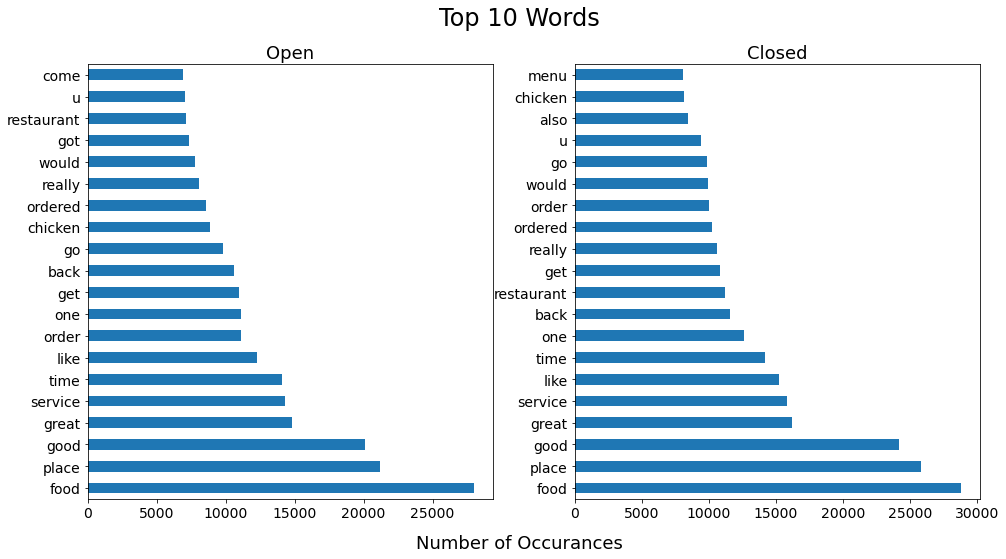

In [22]:
#Plot the Most Frequently Occurring Words

fig, ax = plt.subplots(1, 2, figsize=(16,8))
open_dtm.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[0], fontsize=14)
closed_dtm.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[1], fontsize=14)

ax[0].set_title('Open', fontsize=18)
ax[1].set_title('Closed', fontsize=18)

fig.suptitle('Top 20 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', 
         ha='center', fontsize=18);
#plt.savefig('../presentation/images/top_20_words.png')

#### Bigrams

In [9]:
cvect2 = CountVectorizer(
    ngram_range=(2,2),
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    stop_words=lem_stopwords,
    max_features=500
)

In [10]:
# Vectorize open reviews and create dataframe with words and counts
open_vect2 = cvect2.fit_transform(open_reviews['text'])
open_dtm2 = pd.DataFrame(open_vect2.toarray(), columns = cvect2.get_feature_names())

# Vectorize closed reviews and create dataframe with words and counts
closed_vect2 = cvect2.fit_transform(closed_reviews['text'])
closed_dtm2 = pd.DataFrame(closed_vect2.toarray(), columns = cvect2.get_feature_names())

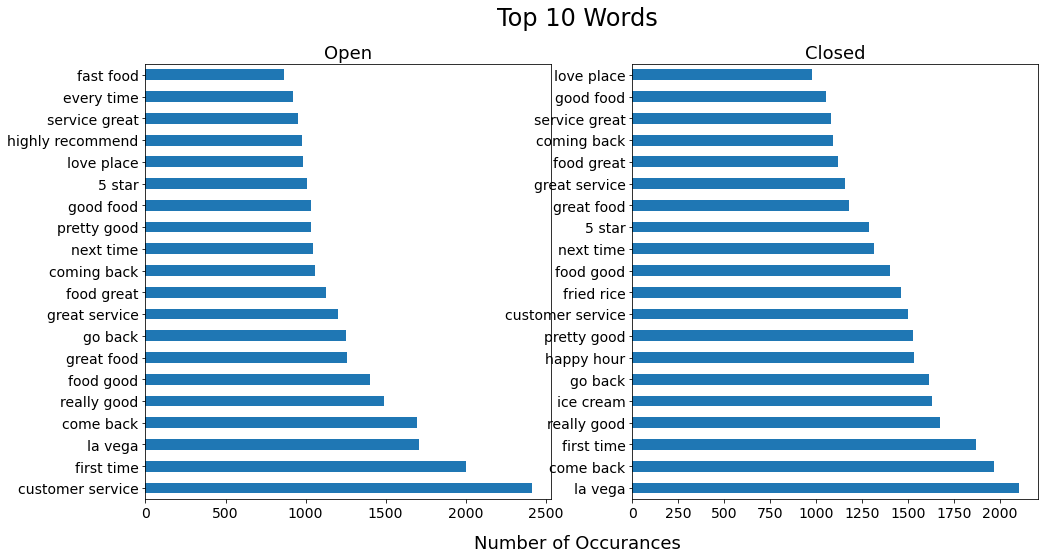

In [11]:
#Plot the Most Frequently Occurring Words

fig, ax = plt.subplots(1, 2, figsize=(16,8))
open_dtm2.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[0], fontsize=14)
closed_dtm2.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[1], fontsize=14)

ax[0].set_title('Open', fontsize=18)
ax[1].set_title('Closed', fontsize=18)

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', 
         ha='center', fontsize=18);
#plt.savefig('../presentation/images/top_20_bigrams.png')

#### Trigrams

In [13]:
cvect3 = CountVectorizer(
    ngram_range=(3,3),
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    stop_words=lem_stopwords,
    max_features=500
)

In [14]:
# Vectorize open reviews and create dataframe with words and counts
open_vect3 = cvect3.fit_transform(open_reviews['text'])
open_dtm3 = pd.DataFrame(open_vect3.toarray(), columns = cvect3.get_feature_names())

# Vectorize closed reviews and create dataframe with words and counts
closed_vect3 = cvect3.fit_transform(closed_reviews['text'])
closed_dtm3 = pd.DataFrame(closed_vect3.toarray(), columns = cvect3.get_feature_names())

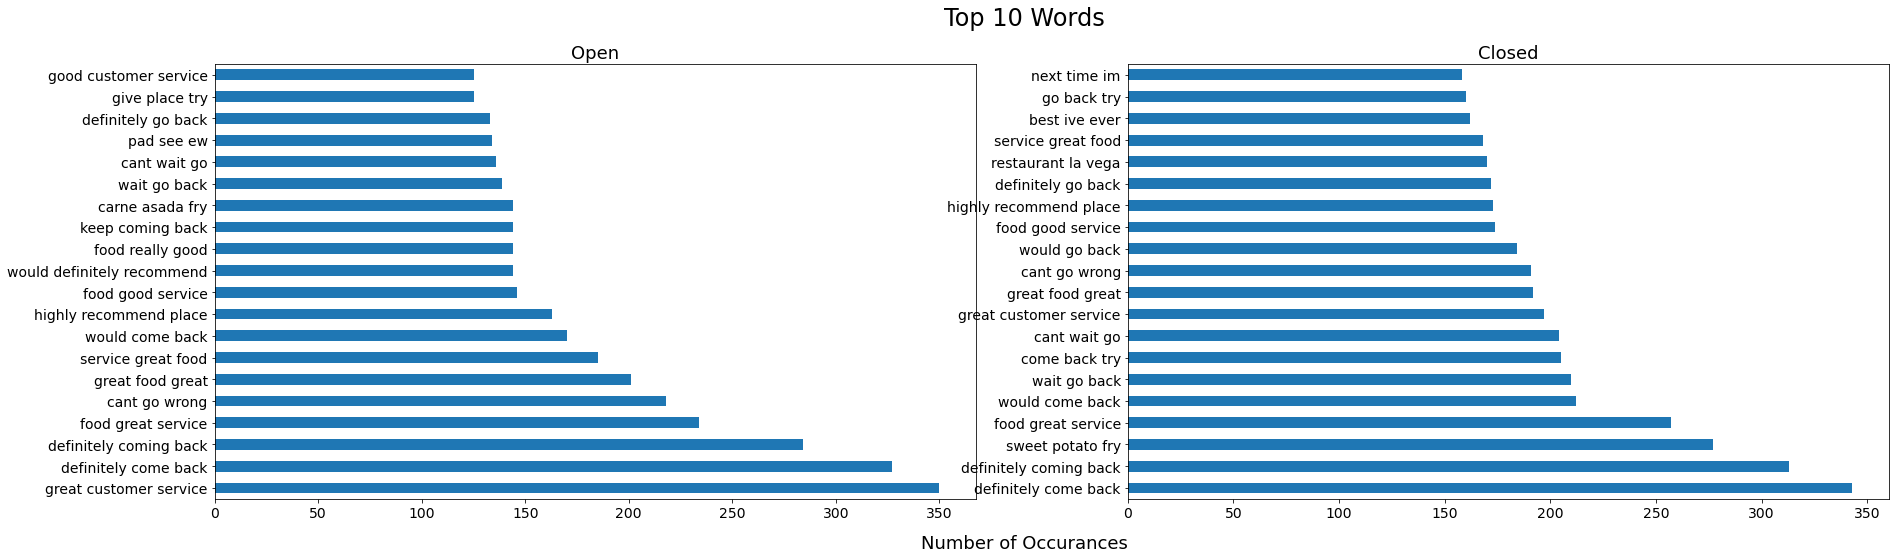

In [18]:
#Plot the Most Frequently Occurring Words

fig, ax = plt.subplots(1, 2, figsize=(30,8))
open_dtm3.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[0], fontsize=14)
closed_dtm3.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[1], fontsize=14)

ax[0].set_title('Open', fontsize=18)
ax[1].set_title('Closed', fontsize=18)

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', 
         ha='center', fontsize=18);
#plt.savefig('../presentation/images/top_10_words.png')

#### Results
The most frequent words are very similar betweenopen and closed restaurants.  Further analysis should be done on other ngrams.

# Sentiment Analysis

In [37]:
sent_cols = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_comp']

In [38]:
# Correlation of Vader Sentiment to open / closed and star rating
corr_cols = sent_cols.copy()
corr_cols.append('stars')
reviews[corr_cols].corr()

,vader_neg,vader_neu,vader_pos,vader_comp,stars
vader_neg,1.000000,0.023895,-0.472359,-0.734676,-0.248377
vader_neu,0.023895,1.000000,-0.892436,-0.292571,-0.177819
vader_pos,-0.472359,-0.892436,1.000000,0.589505,0.268872
vader_comp,-0.734676,-0.292571,0.589505,1.000000,0.285103
stars,-0.248377,-0.177819,0.268872,0.285103,1.000000


In [43]:
# 10 reviews with most negative sentiment
reviews.sort_values('vader_neg', ascending=False)['text'][:10]

41994    Dirty floors, Dirty tables, Terrible customer ...
21390    disgusting kitchen area, rude service and the ...
4202     Rude and Obnoxious Owner/Server, Very High pri...
4874     Avoid at all costs. Horrible service and horri...
11807    Bad customer service and very bad pho not reco...
35745    Food were too salty. The waitress was rude unp...
68807    Terrible. Don't go even if you're forced to.Wa...
5143     Worst place ever.    Food sucks!!! The bar is ...
52667                             Nıce margarita bad food.
11184    Worst experience they lie about changing recip...
Name: text, dtype: object

In [47]:
# 10 reviews with most positive sentiment
reviews.sort_values('vader_pos', ascending=False)['text'][:10]

23153                                                Yummy
35928                                     amazing meal!!!!
38254                                     awesome falafel!
68042    Friendly attentive service, peaceful, enjoyabl...
44033                           Hand down Best Falafels!!!
59457    Great tacos, great atmosphere, awesome taco's....
55133    Great service, great food, good burgers, great...
63315               Sooo good. Love tigers blood. Winning!
65428         Pretty solid chicken.  Nice clean place too!
65120    Super fabulous food!!!  Nice atmosphere and gr...
Name: text, dtype: object

In [39]:
open_reviews[sent_cols].describe()

,vader_neg,vader_neu,vader_pos,vader_comp
count,37211.000000,37211.000000,37211.000000,37211.000000
mean,0.043297,0.751118,0.205585,0.618204
std,0.057498,0.110832,0.126943,0.573986
min,0.000000,0.000000,0.000000,-0.998000
25%,0.000000,0.687000,0.110000,0.592700
50%,0.024000,0.767000,0.189000,0.906900
75%,0.066000,0.829000,0.284000,0.966400
max,0.605000,1.000000,1.000000,0.999800


In [41]:
closed_reviews[sent_cols].describe()

,vader_neg,vader_neu,vader_pos,vader_comp
count,36067.000000,36067.000000,36067.000000,36067.000000
mean,0.041632,0.755046,0.203323,0.678071
std,0.053370,0.105888,0.118789,0.533779
min,0.000000,0.168000,0.000000,-0.998600
25%,0.000000,0.697000,0.118000,0.716100
50%,0.026000,0.771000,0.187000,0.928700
75%,0.061000,0.828000,0.271000,0.975400
max,0.628000,1.000000,0.832000,0.999800


#### Results
Although the vader sentiment seems to have done a pretty good job detecting the most positive and negative reviews, it does not not seem to be highly correltated to whether or not the restaurant is open.  It is, however, related to the star rating of the restaurant.

In [49]:
closed_reviews

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,user_id,review_stars,text,date,char_count,word_count,vader_neg,vader_neu,vader_pos,vader_comp
2431,viHcW-LLmOxBMHFm0jxPvQ,Grand Cafe,2411 W Sahara Ave,Las Vegas,NV,89102,36.142946,-115.174936,3.0,111,...,L8P5OWO1Jh4B2HLa1Fnbng,3.0,Though we have been to Palace Station countles...,2015-11-06 09:10:18,495,86,0.022,0.944,0.034,0.2589
2432,viHcW-LLmOxBMHFm0jxPvQ,Grand Cafe,2411 W Sahara Ave,Las Vegas,NV,89102,36.142946,-115.174936,3.0,111,...,2_8FRNMYopk_gQmPhq-vrw,3.0,"Spent sometimes in this remodeled casino, drop...",2018-08-24 03:24:57,335,57,0.000,0.884,0.116,0.7269
2433,viHcW-LLmOxBMHFm0jxPvQ,Grand Cafe,2411 W Sahara Ave,Las Vegas,NV,89102,36.142946,-115.174936,3.0,111,...,jn6UGXNFPzKg-xNb5KVY0w,2.0,The food is 5 stars!! But the one waitress I h...,2016-01-04 08:46:28,1092,228,0.125,0.788,0.088,-0.9198
2434,viHcW-LLmOxBMHFm0jxPvQ,Grand Cafe,2411 W Sahara Ave,Las Vegas,NV,89102,36.142946,-115.174936,3.0,111,...,skmMotDjzynS0j4LxyFPzA,1.0,Horrible service by Tiffany and Wayne. Literal...,2018-05-29 09:32:35,845,147,0.126,0.832,0.042,-0.9129
2435,viHcW-LLmOxBMHFm0jxPvQ,Grand Cafe,2411 W Sahara Ave,Las Vegas,NV,89102,36.142946,-115.174936,3.0,111,...,cWAkb8yR3T-gzITk-fPlbQ,1.0,Kandeli didn't really like the fact we were ea...,2018-07-26 11:08:16,445,84,0.034,0.905,0.061,0.5222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73273,1qTx9z8RMz7RIYKAfnpZ0A,Lillie's Asian Cuisine,129 E Fremont St,Las Vegas,NV,89101,36.170349,-115.144506,3.5,121,...,5xaFHey_NjidLtugo0mdAw,3.0,Sitting here for what seems like it has been f...,2019-10-13 04:25:49,533,97,0.018,0.711,0.271,0.9861
73274,INzLc1Y0JNQzIHjPH2Nbeg,Fuzzy's Taco Shop,7080 S Rainbow Blvd,Las Vegas,NV,89118,36.060044,-115.241666,3.5,252,...,acyl_5237y5MZMgnx_VeNA,5.0,I remember this chain from Texas and LOVE it!!...,2017-03-25 19:55:57,115,22,0.000,0.536,0.464,0.9485
73275,INzLc1Y0JNQzIHjPH2Nbeg,Fuzzy's Taco Shop,7080 S Rainbow Blvd,Las Vegas,NV,89118,36.060044,-115.241666,3.5,252,...,o-4WGmqWdNiiQFctHdjC8Q,4.0,Love Fuzzy's Taco Shop. It's become my new ad...,2017-01-11 19:53:55,1161,221,0.050,0.794,0.156,0.9798
73276,INzLc1Y0JNQzIHjPH2Nbeg,Fuzzy's Taco Shop,7080 S Rainbow Blvd,Las Vegas,NV,89118,36.060044,-115.241666,3.5,252,...,HyDMhqf_ru13zau_OCyNBw,1.0,Found a part of a rubber glove in my tacos. W...,2017-08-15 19:23:56,172,34,0.057,0.777,0.166,0.4949
